# Telco Customer Churn - data mining and machine learning pipeline

## Import libraries

In [1]:
# IO
import os
import pathlib
from pathlib import Path

# Data processing
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Unsupervised
import sklearn.metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# Supervised
from sklearn.model_selection import train_test_split, GridSearchCV
## Models
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Association rules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Define custom functions

### Data processing

Map categorical data to numerical

In [2]:
def map_categorical_to_num(df, one_hot=False):
    categorical_cols = [c for c in df.columns if (df[c].dtype == 'object' or df[c].dtype == 'category')] #select categorical columns
    attr_maps = {} #initialize dictionary
    for col in categorical_cols:
        if one_hot==True:
            if df[col].nunique() == 2:
                df[col], uniques = pd.factorize(df[col])
                attr_maps[col] = dict(zip(uniques, range(len(uniques)))) #fill dictionary
            else:
                df = pd.get_dummies(df, columns=[col])
        else:
            df[col], uniques = pd.factorize(df[col]) #pd.factorize encodes the object as an enumerated type or categorical variable
            attr_maps[col] = dict(zip(uniques, range(len(uniques)))) #fill dictionary
    return df, attr_maps

Binning numerical value

In [3]:
def map_numerical_to_categorical(df,column):
    df[column+'bin'] = pd.qcut(df[column], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    df = df.drop([column],axis=1)
    return df

### Visualizations

Plot the KDE's of an attribute given the value of the binary target attribute. The attribute and the target must be strings and the target values should already be converted to 0,1

In [4]:
def kdeplot_binary_target(df,attribute,target):
    plt.figure(figsize=(9, 4))
    plt.title("KDE for {}".format(attribute))
    ax0 = sns.kdeplot(df[df[target] == 0][attribute].dropna(), color= 'navy', label= target+': No')
    ax1 = sns.kdeplot(df[df[target] == 1][attribute].dropna(), color= 'orange', label= target+': Yes')
    plt.legend()

We define a bar plot for categorical data which separates churn from no churn

In [5]:
def barplot_percentage_binary_target(df, attribute, target, label_dict, orient='v', axis_name="percentage of customers"):
    g = df.groupby(attribute)[target].value_counts().rename(axis_name).reset_index() #new data frame storing percentage
    g[axis_name] = g[axis_name]/len(df)

        
    # Reverse mapping for attribute and target
    reverse_attr_map = {v: k for k, v in label_dict.get(attribute, {}).items()}
    reverse_target_map = {v: k for k, v in label_dict.get(target, {}).items()}
    
    # Apply reverse mapping
    if reverse_attr_map:
        g[attribute] = g[attribute].map(reverse_attr_map)
    if reverse_target_map:
        g[target] = g[target].map(reverse_target_map)
    
    # Plot
    if orient == 'v':
        ax = sns.barplot(x=attribute, y=axis_name, hue=target, data=g, orient=orient)
        ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])
    else:
        ax = sns.barplot(x=axis_name, y=attribute, hue=target, data=g, orient=orient)
        ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])
    
    plt.title(f"Distribution of {target} by {attribute}")
    plt.tight_layout()
    plt.show()

Now do the same thing for multiple columns

In [6]:
def multi_barplot_percentage(df, cols, target, label_dict, ncols=3):
    nrows = -(-len(cols) // ncols)  # Ceiling division
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
    axes = axes.flatten()

    for i, col in enumerate(cols):
        # Prepare data
        g = df.groupby(col)[target].value_counts().rename("Percentage").reset_index()
        g["Percentage"] = g["Percentage"] / len(df)

        # Reverse mapping
        attr_map = {v: k for k, v in label_dict.get(col, {}).items()}
        target_map = {v: k for k, v in label_dict.get(target, {}).items()}
        if attr_map:
            g[col] = g[col].map(attr_map)
        if target_map:
            g[target] = g[target].map(target_map)

        # Plot
        sns.barplot(x=col, y="Percentage", hue=target, data=g, ax=axes[i])
        axes[i].set_title(col)
        axes[i].set_yticklabels(['{:,.0%}'.format(y) for y in axes[i].get_yticks()])

    # Hide unused axes if any
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

### Cluster evaluation

In [7]:
def compute_sse_hierarchical(X, labels):
    sse = 0
    X = np.array(X)
    labels = np.array(labels)
    for cluster in np.unique(labels):
        cluster_points = X[labels == cluster]
        centroid = cluster_points.mean(axis=0)
        sse += ((cluster_points - centroid) ** 2).sum()
    return sse

In [8]:
def knee_method_hierarchical(X, max_clusters=10, method='ward'):
    sse_list = list()
    data_link = linkage(X, method=method, metric='euclidean')
    for k in range(1, max_clusters + 1):
        labels = fcluster(data_link, t=k, criterion='maxclust')
        sse = compute_sse_hierarchical(X, labels)
        sse_list.append(sse)
    return sse_list

### Supervised learning models

In [9]:
def logistic_regression(frame, grid):
    logit = Model(LogisticRegression, frame, metrics)
    print_result(logit.grid_search('roc_auc', grid), "cross-validation")
    print_result(logit.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", logit.hyperparameters)

In [10]:
def svc_rbf(frame, grid):
    rbf = Model(SVC, frame, metrics, fixed_params= {'kernel': 'rbf', 'probability': True})
    print_result(rbf.grid_search('roc_auc', grid, num_folds=4), "cross-validation")
    print_result(rbf.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", rbf.hyperparameters)

In [11]:
def random_forest(frame,grid):
    rf = Model(RandomForestClassifier, frame, metrics)
    print_result(rf.grid_search('roc_auc', grid, num_folds=4), "cross-validation")
    print_result(rf.train_and_evaluate_test(), "test set")
    print("Best hyperparameters:", rf.hyperparameters)

In [12]:
def decision_tree(frame, grid):
    dt = Model(DecisionTreeClassifier, frame, metrics, fixed_params={})
    print_result(dt.grid_search('roc_auc', grid, num_folds=4), "cross-validation")
    print_result(dt.train_and_evaluate_test(), "test set")
    dt.plot_roc_curve()
    print("Best hyperparameters:", dt.hyperparameters)

In [13]:
def print_result(results, sufix = ""):
    """ Function for printing the results nicely. """
    msg = ""
    for result in results:
        msg += "| {}: {:.4f} ".format(result[0], result[1])
    print("{}- {}".format(msg, sufix))

## Supervised learning model class

In [14]:
class Model():
    def __init__(self, classifier, frame, metrics, fixed_params = {},
                 test_size=0.2, random_seed=42):
        self.estimator = classifier
        self.seed = random_seed
        self.metrics = metrics
        self.hyperparameters = {}
        self.fixed_params = fixed_params
        self.fixed_params['random_state'] = random_seed
        if classifier == KNeighborsClassifier:
            del self.fixed_params['random_state']

        # First divide data in learning set and final test set
        self.train, self.test = train_test_split(frame, test_size=test_size, random_state= self.seed)
        self.predictors = [c for c in self.train.columns if c not in ['customerID', 'Churn']]

    def grid_search(self, fit_metric, params, num_folds=10, num_repeats=3):
        """ Save the best params to self.hyperparameters. """
        print(self.fixed_params)
        stratified_cv = RepeatedStratifiedKFold(n_splits=num_folds, n_repeats=num_repeats, random_state=self.seed)
        gs = GridSearchCV(self.estimator(**self.fixed_params), param_grid= params,
                          scoring=self.metrics, cv=stratified_cv, refit= fit_metric)
        gs.fit(self.train[self.predictors], self.train['Churn'])
        self.hyperparameters = gs.best_params_
        return [(m, gs.cv_results_['mean_test_{}'.format(m)][gs.best_index_]) for m in self.metrics]
    
    def train_and_evaluate_test(self):
        """ Train classifier on the full train set and evaluate the performance on the test set. """
        params = {**self.hyperparameters, **self.fixed_params}
        clf = self.estimator(**params).fit(self.train[self.predictors], self.train['Churn'])
        y_pred = clf.predict(self.test[self.predictors])
        y_prob = clf.predict_proba(self.test[self.predictors])[:, 1]
        results = list()
        for m in self.metrics:
            if m == 'roc_auc':
                # For calculating roc auc we need the probability of target==1
                results.append((m, roc_auc_score(self.test['Churn'], y_prob)))
            else:
                # For the other metrics we can simply use the predicted label (0 or 1)
                results.append((m, eval("{}_score".format(m))(self.test['Churn'], y_pred)))

        # Add confusion matrix
        cm = confusion_matrix(self.test['Churn'], y_pred)
        cm_df = pd.DataFrame(cm,
                            index=['Actual No', 'Actual Yes'],
                            columns=['Predicted No', 'Predicted Yes'])
        print("Confusion Matrix:\n", cm_df)
        
        return results

    def plot_roc_curve(self):
        """ Plot the ROC curve on the test set. """
        params = {**self.hyperparameters, **self.fixed_params}
        clf = self.estimator(**params).fit(self.train[self.predictors], self.train['Churn'])
        y_prob = clf.predict_proba(self.test[self.predictors])[:, 1]
        fpr, tpr, thresholds = roc_curve(self.test['Churn'], y_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.4f})'.format(roc_auc))
        plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()

## Main

### Import data

Grab working folder and data folders in a OS-agnostic way.

In [15]:
CodeDirectory = Path(os.path.abspath(''))
DATASET_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_data","")
LOGGING_FOLDER = os.path.join(str(CodeDirectory.parent.absolute()), "_output_data","")

In [16]:
telco_df = pd.read_csv(DATASET_FOLDER + "telco.csv", 
                 sep=',')
telco_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [17]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Create data-frame copies for different purposes

We create copies of the original data-frame so that we can manipulate them according to specific purposes. E.G., for association rule mining, we will need a data frame whose column encode binary information --> we bin the numerical values and use one-hot encoding

AR dataframe

In [18]:
telco_df_ar = pd.read_csv(DATASET_FOLDER + "telco.csv", 
                 sep=',')

One-hot encoding for categorical attributes only

In [19]:
telco_df_oh = pd.read_csv(DATASET_FOLDER + "telco.csv", 
                 sep=',')

### Data exploration and preprocessing

#### Drop useless attributes

The customerID attribute has no statistical significance, so we can safely drop it

In [20]:
telco_df = telco_df.drop(['customerID'],axis=1)
telco_df_ar = telco_df_ar.drop(['customerID'],axis=1)

#### Check for missing values

Looking at the output of .info(), there appears to be no missing value. However, the attribute TotalCharges being an object and not a float64 seems suspicious, maybe some of its values are not numeric.

In [21]:
non_numeric_mask = pd.to_numeric(telco_df['TotalCharges'], errors='coerce').isna()
telco_df[non_numeric_mask]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


The non numeric values correspond to an empty space ' '. All these customers have 0 tenure, so we can conclude that we are dealing with customers who have not paid their bill yet. We can replace these values with 0

In [22]:
telco_df['TotalCharges'] = pd.to_numeric(telco_df['TotalCharges'], errors='coerce')
# Drop missing values
telco_df.dropna(inplace=True)
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   object 
 6   MultipleLines     7032 non-null   object 
 7   InternetService   7032 non-null   object 
 8   OnlineSecurity    7032 non-null   object 
 9   OnlineBackup      7032 non-null   object 
 10  DeviceProtection  7032 non-null   object 
 11  TechSupport       7032 non-null   object 
 12  StreamingTV       7032 non-null   object 
 13  StreamingMovies   7032 non-null   object 
 14  Contract          7032 non-null   object 
 15  PaperlessBilling  7032 non-null   object 
 16  PaymentMethod     7032 non-null   object 
 17  

#### Convert categorical data to numeric

First, we identify the categorical columns. Scanning over those, we replace the categorical values with numerical ones. We also save a dictionary keeping track of the conversion.

In [23]:
telco_df_num = telco_df

In [24]:
telco_df_num, category_dictionary = map_categorical_to_num(telco_df_num)
telco_df_num.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,29.85,29.85,0
1,1,0,1,0,34,1,1,0,1,1,1,0,0,0,1,1,1,56.95,1889.50,0
2,1,0,1,0,2,1,1,0,1,0,0,0,0,0,0,0,1,53.85,108.15,1
3,1,0,1,0,45,0,0,0,1,1,1,1,0,0,1,1,2,42.30,1840.75,0
4,0,0,1,0,2,1,1,1,0,1,0,0,0,0,0,0,0,70.70,151.65,1


In [25]:
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   int64  
 1   SeniorCitizen     7032 non-null   int64  
 2   Partner           7032 non-null   int64  
 3   Dependents        7032 non-null   int64  
 4   tenure            7032 non-null   int64  
 5   PhoneService      7032 non-null   int64  
 6   MultipleLines     7032 non-null   int64  
 7   InternetService   7032 non-null   int64  
 8   OnlineSecurity    7032 non-null   int64  
 9   OnlineBackup      7032 non-null   int64  
 10  DeviceProtection  7032 non-null   int64  
 11  TechSupport       7032 non-null   int64  
 12  StreamingTV       7032 non-null   int64  
 13  StreamingMovies   7032 non-null   int64  
 14  Contract          7032 non-null   int64  
 15  PaperlessBilling  7032 non-null   int64  
 16  PaymentMethod     7032 non-null   int64  
 17  

In [26]:
category_dictionary

{'gender': {'Female': 0, 'Male': 1},
 'Partner': {'Yes': 0, 'No': 1},
 'Dependents': {'No': 0, 'Yes': 1},
 'PhoneService': {'No': 0, 'Yes': 1},
 'MultipleLines': {'No phone service': 0, 'No': 1, 'Yes': 2},
 'InternetService': {'DSL': 0, 'Fiber optic': 1, 'No': 2},
 'OnlineSecurity': {'No': 0, 'Yes': 1, 'No internet service': 2},
 'OnlineBackup': {'Yes': 0, 'No': 1, 'No internet service': 2},
 'DeviceProtection': {'No': 0, 'Yes': 1, 'No internet service': 2},
 'TechSupport': {'No': 0, 'Yes': 1, 'No internet service': 2},
 'StreamingTV': {'No': 0, 'Yes': 1, 'No internet service': 2},
 'StreamingMovies': {'No': 0, 'Yes': 1, 'No internet service': 2},
 'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
 'PaperlessBilling': {'Yes': 0, 'No': 1},
 'PaymentMethod': {'Electronic check': 0,
  'Mailed check': 1,
  'Bank transfer (automatic)': 2,
  'Credit card (automatic)': 3},
 'Churn': {'No': 0, 'Yes': 1}}

#### Normalize numerical data

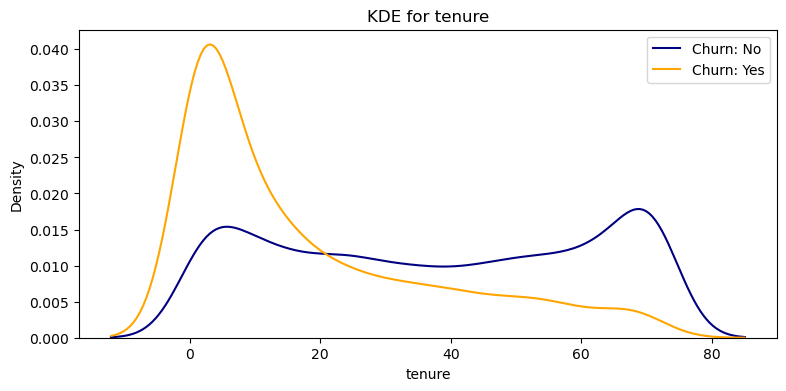

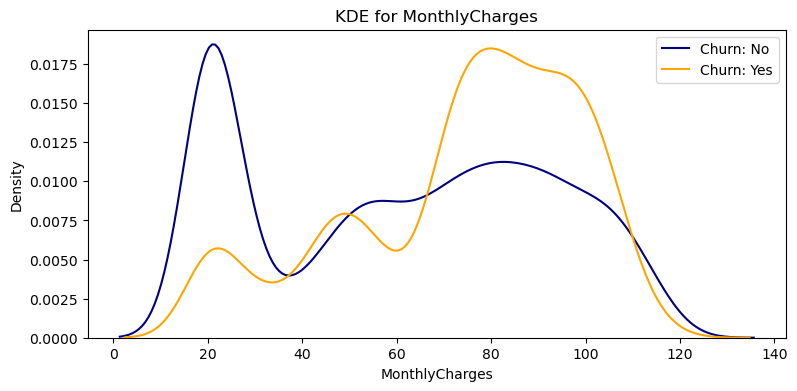

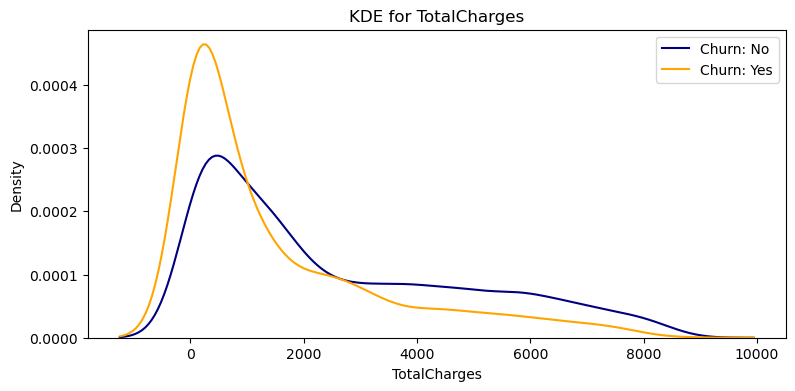

In [27]:
kdeplot_binary_target(telco_df,'tenure','Churn')
kdeplot_binary_target(telco_df,'MonthlyCharges','Churn')
kdeplot_binary_target(telco_df,'TotalCharges','Churn')

The ranges of these numerical data are wildly different. In order to build better models, we can normalize the data

In [28]:
columns_to_scale = ['tenure', 'MonthlyCharges', 'TotalCharges']
telco_df[columns_to_scale] = StandardScaler().fit_transform(telco_df[columns_to_scale])

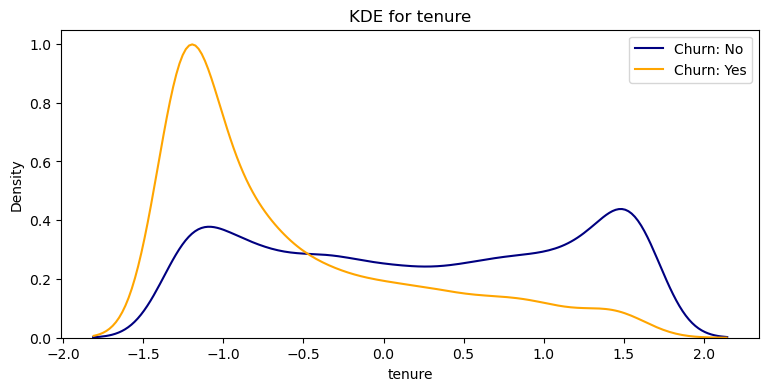

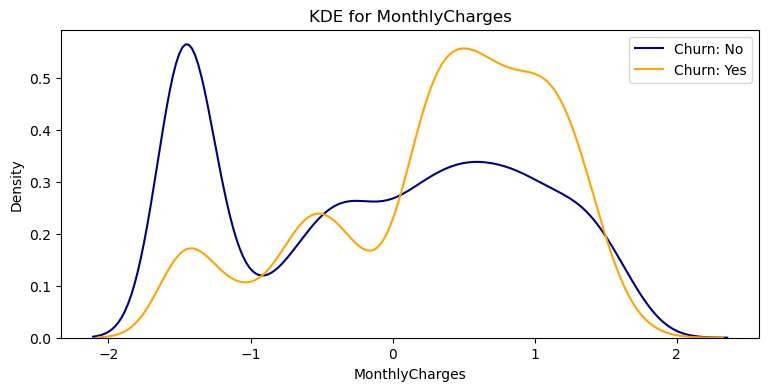

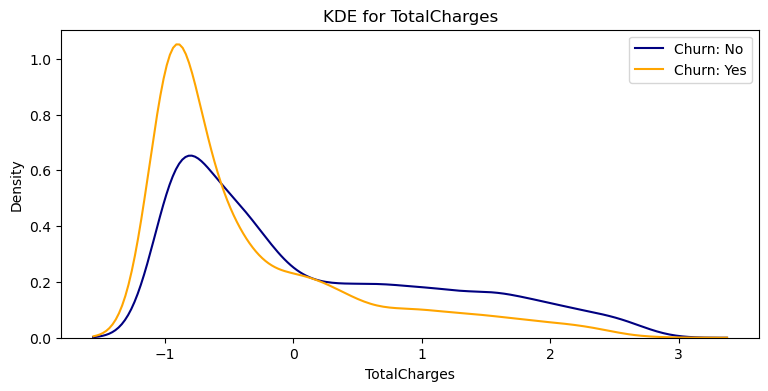

In [29]:
kdeplot_binary_target(telco_df,'tenure','Churn')
kdeplot_binary_target(telco_df,'MonthlyCharges','Churn')
kdeplot_binary_target(telco_df,'TotalCharges','Churn')

We can already see that these attributes have some predictive properties wrt the churn. Particularly for the tenure, we recognize that churn is much more likely in the range 0-20 (new customers are more likely to churn), in the range 20-40 there is no strong difference in churn probability, in the range 40-60 we start seeing more separation and in the range 60-(>80) churn is very unlikely relatively speaking (long-standing customers are less likely to churn). We could encode this information into a new variable which bins the tenure into 4 buckets, corresponding to the ranges described above

#### Explore distributions and correlations

##### Gender and age

/tmp/ipykernel_37954/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


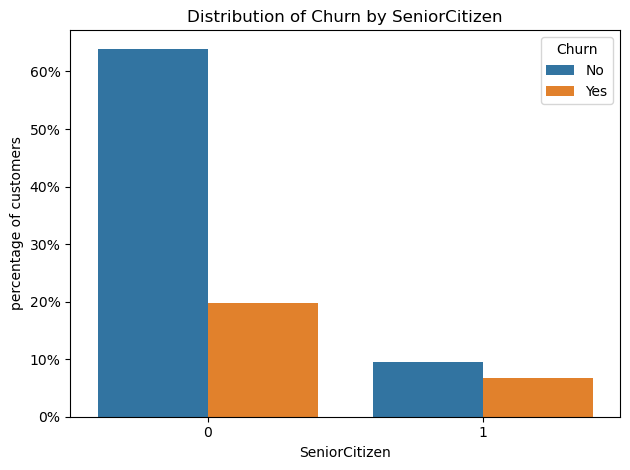

In [30]:
barplot_percentage_binary_target(telco_df,'SeniorCitizen','Churn', category_dictionary)

Senior citizens are relatively more likely to churn

/tmp/ipykernel_37954/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


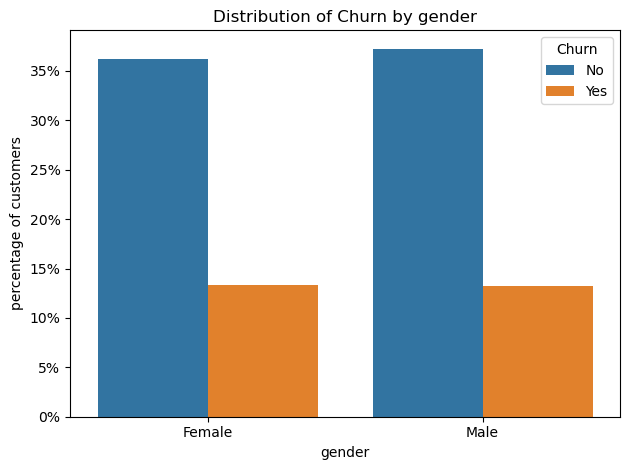

In [31]:
barplot_percentage_binary_target(telco_df,'gender','Churn', category_dictionary)

No discernable difference in churn rate based on gender.

##### Partners and dependents

/tmp/ipykernel_37954/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


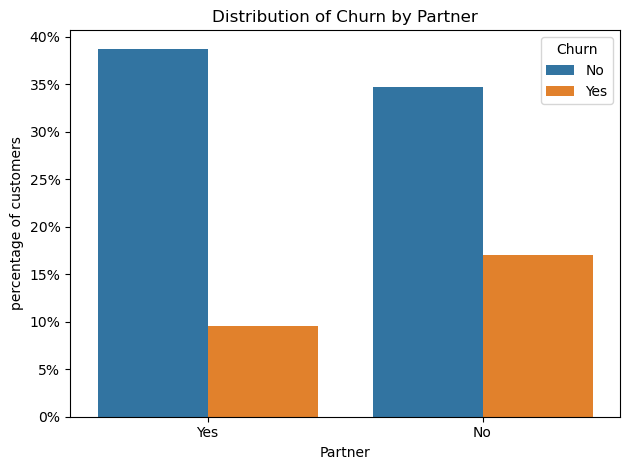

/tmp/ipykernel_37954/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


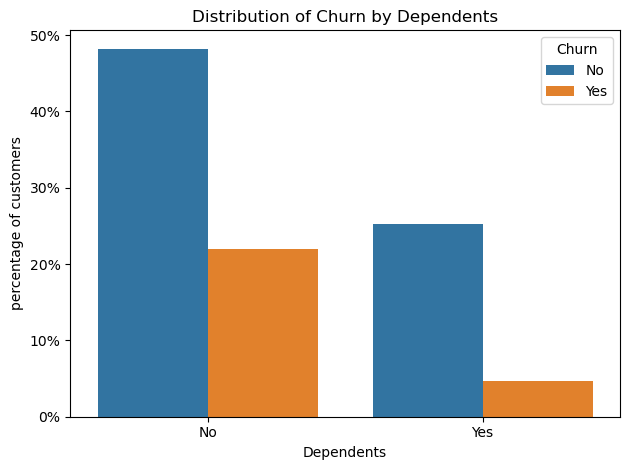

In [32]:
barplot_percentage_binary_target(telco_df,'Partner','Churn', category_dictionary)
barplot_percentage_binary_target(telco_df,'Dependents','Churn', category_dictionary)

Customers with partners or dependents are less likely to churn

##### Services

/tmp/ipykernel_37954/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


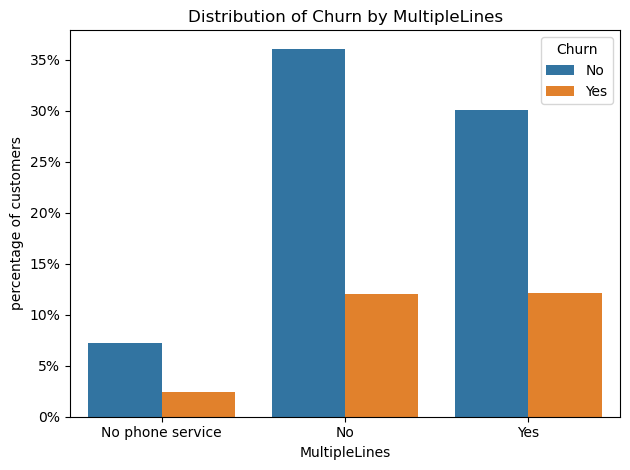

/tmp/ipykernel_37954/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


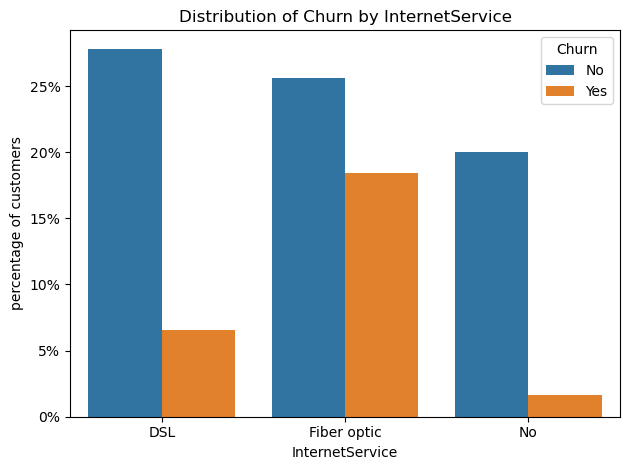

In [33]:
barplot_percentage_binary_target(telco_df,'MultipleLines','Churn', category_dictionary)
barplot_percentage_binary_target(telco_df,'InternetService','Churn', category_dictionary)

Customers with multiple active lines are slightly more likely to churn (they may be more interested in finding better deals)
Customers with faster internet are more likely to churn (may be due to them being more tech savvy and able to find better deals)

/tmp/ipykernel_37954/2487453796.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['{:,.0%}'.format(y) for y in axes[i].get_yticks()])
/tmp/ipykernel_37954/2487453796.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['{:,.0%}'.format(y) for y in axes[i].get_yticks()])
/tmp/ipykernel_37954/2487453796.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['{:,.0%}'.format(y) for y in axes[i].get_yticks()])
/tmp/ipykernel_37954/2487453796.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_yticklabels(['{:,.0%}'.format(y) for y in axes[i].get_yticks()])
/tmp/ipykernel_3

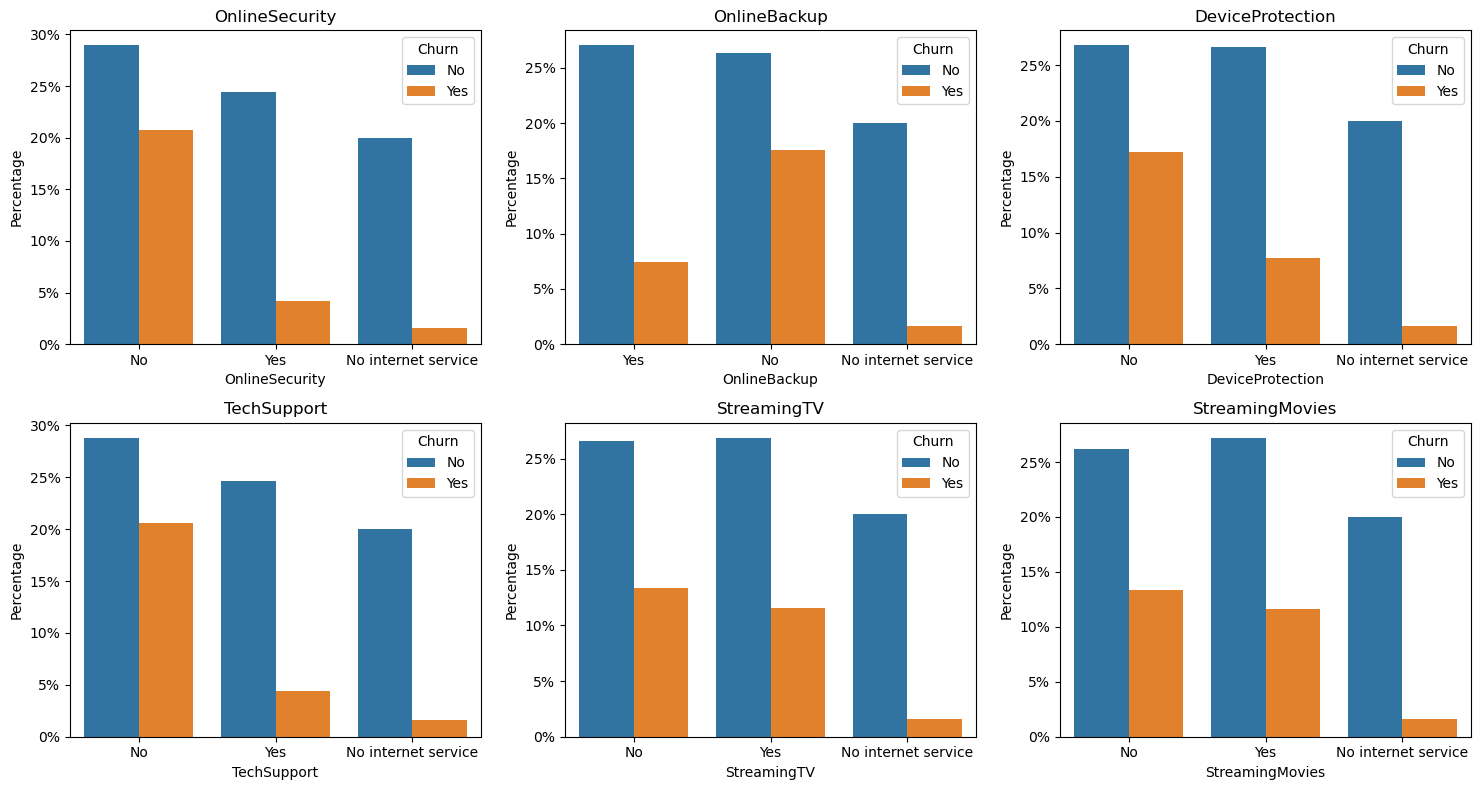

In [34]:
additional_services_columns = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
multi_barplot_percentage(telco_df,additional_services_columns,'Churn', category_dictionary)

##### Type of contract

/tmp/ipykernel_37954/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


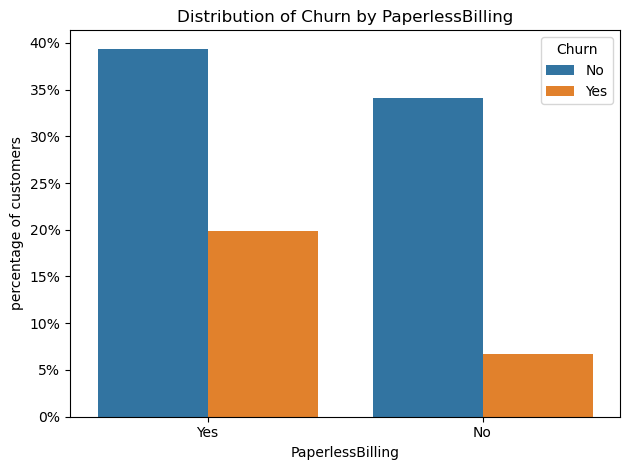

/tmp/ipykernel_37954/3242246602.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in ax.get_yticks()])


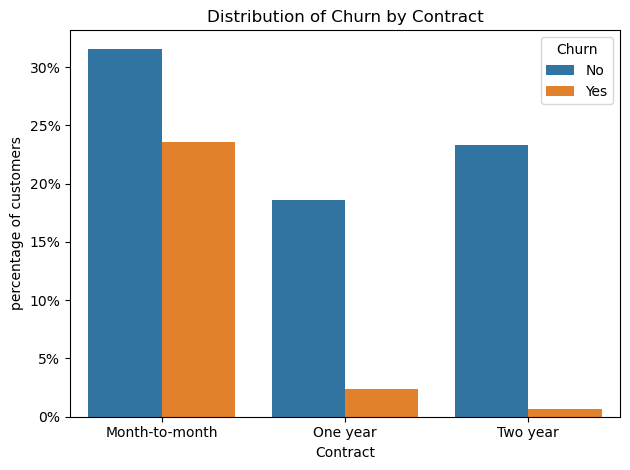

/tmp/ipykernel_37954/3242246602.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in ax.get_xticks()])


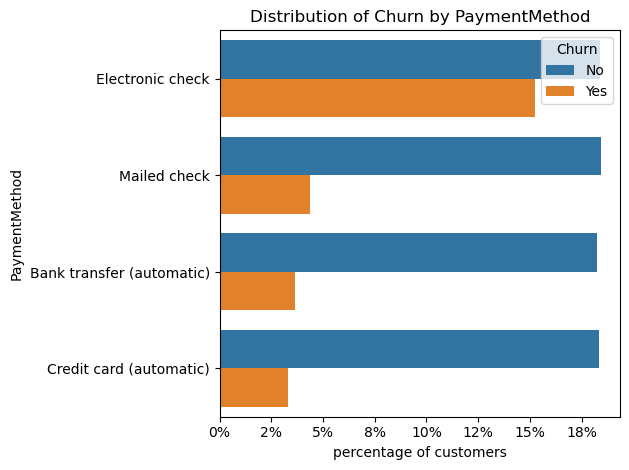

In [35]:
barplot_percentage_binary_target(telco_df,'PaperlessBilling','Churn', category_dictionary)
barplot_percentage_binary_target(telco_df,'Contract','Churn', category_dictionary)
barplot_percentage_binary_target(telco_df,'PaymentMethod','Churn', category_dictionary, orient='h')

##### Correlations

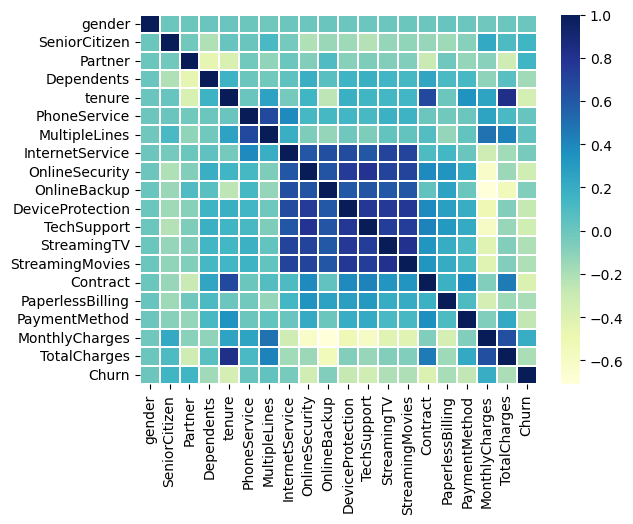

In [36]:
corr = telco_df.corr()
ax = sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, 
                 linewidths=.2, cmap="YlGnBu")

##### Feature importance

/tmp/ipykernel_37954/325296606.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')


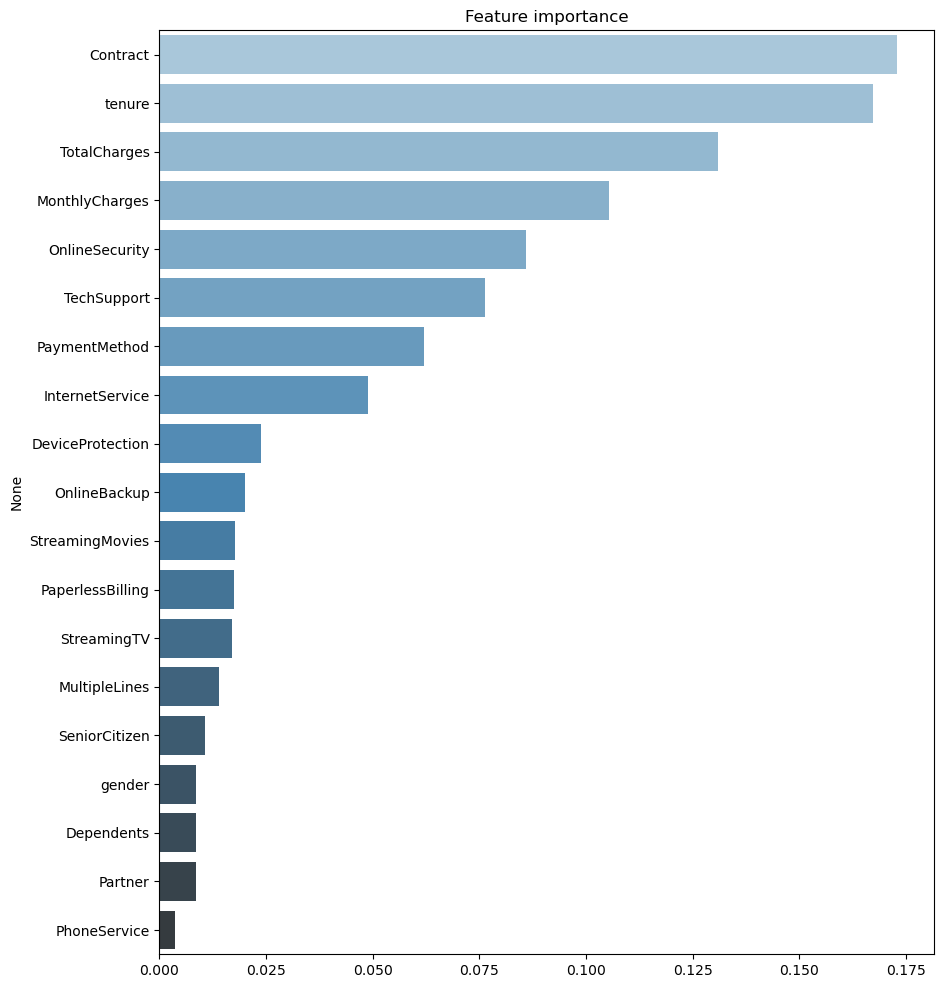

In [37]:
params = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}
x, y = telco_df.drop('Churn',axis=1), telco_df['Churn']
# Fit RandomForest Classifier
clf = RandomForestClassifier(**params)
clf = clf.fit(x, y)
# Plot features importances
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')

### Unsupervised learning

#### Hierarchical clustering

Drop Churn target for unsupervised learning

In [38]:
X = telco_df.drop('Churn',axis=1)
true_labels = np.asarray(telco_df['Churn'])

Create distance list

In [39]:
data_dist = pdist(X, metric='euclidean')

Create linkage

In [40]:
data_link = linkage(data_dist, method='ward', metric='euclidean')

Plot the dendrogram

We will use two methods: Ward and Min, whose strenghts and weaknesses balance out (Ward is less sensitive to noise but biased towards globular shapes, while Min can handle non elliptical shapes but is sensitive to noise)

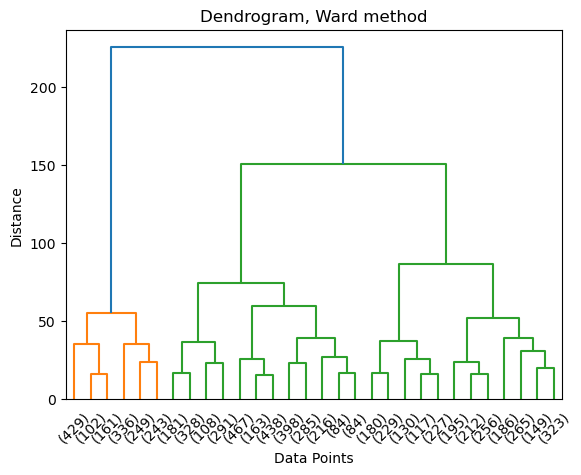

In [41]:
dendrogram(data_link, truncate_mode='lastp')
plt.title("Dendrogram, Ward method")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

Change method from Ward to single

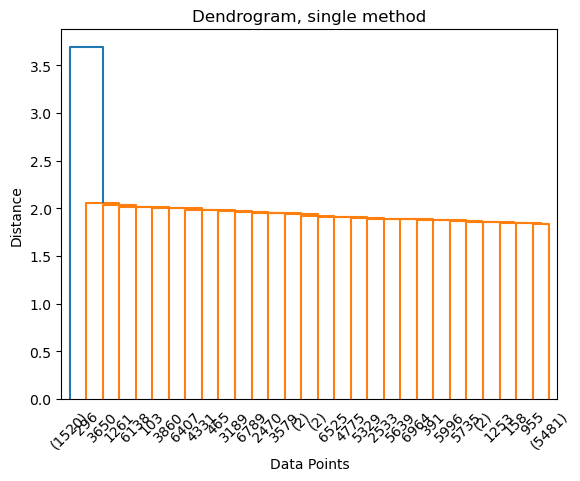

In [42]:
data_link_single = linkage(data_dist, method='single', metric='euclidean')
dendrogram(data_link_single, truncate_mode='lastp')
plt.title("Dendrogram, single method")
plt.xlabel("Data Points")
plt.ylabel("Distance")
plt.show()

It looks like there are 2-3 natural clusters, we can confirm that using a knee method based on an internal measure (SSE)

In [43]:
sse_list_ward = knee_method_hierarchical(X,method='ward')
sse_list_min = knee_method_hierarchical(X,method='single')

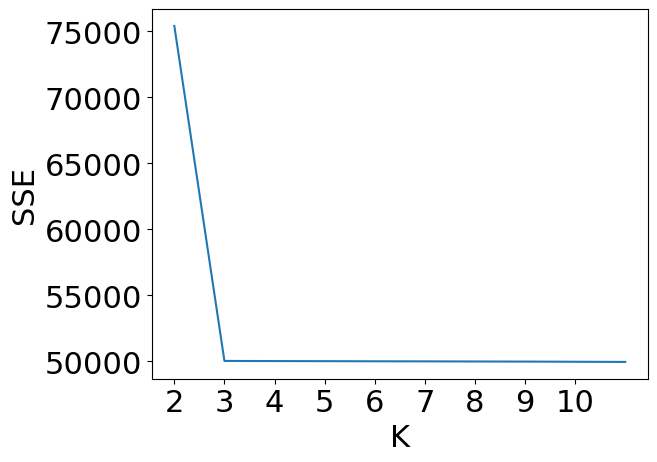

In [44]:
plt.plot(range(2, len(sse_list_min) + 2), sse_list_min)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks([2,3,4,5,6,7,8,9,10])
plt.show()

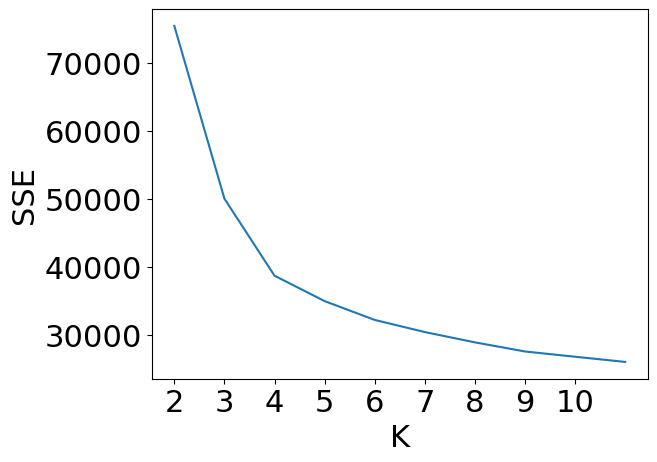

In [45]:
plt.plot(range(2, len(sse_list_ward) + 2), sse_list_ward)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks([2,3,4,5,6,7,8,9,10])
plt.show()

#### K-means

In [46]:
np.unique(true_labels, return_counts=True)

(array([0, 1]), array([5163, 1869]))

In [47]:
kmeans_2 = KMeans(n_clusters=2, random_state=42)
kmeans_2.fit(X)
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_3.fit(X)

KMeans(n_clusters=3, random_state=42)

In [48]:
np.unique(kmeans_2.labels_, return_counts=True)

(array([0, 1], dtype=int32), array([5512, 1520]))

In [49]:
np.unique(kmeans_3.labels_, return_counts=True)

(array([0, 1, 2], dtype=int32), array([2215, 1520, 3297]))

In [50]:
plt.plot(range(2, len(sse_list) + 2), sse_list)
plt.ylabel('SSE', fontsize=22)
plt.xlabel('K', fontsize=22)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xticks([2,3,4,5,6,7,8,9,10])
plt.show()

NameError: name 'sse_list' is not defined

##### Number of clusters estimation

In [ ]:
sse_list = list()
max_k = 10
for k in range(2, max_k + 1):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=300)
    kmeans.fit(X)
    
    sse = kmeans.inertia_
    sse_list.append(sse)

##### Internal evaluation

In [ ]:
print('SSE %s' % kmeans_2.inertia_)
print('Silhouette %s' % metrics.silhouette_score(X, kmeans_2.labels_))
print('Separation %s' % metrics.davies_bouldin_score(X, kmeans_2.labels_))

SSE 50033.03298092435
Silhouette 0.3703636555463324
Separation 1.0181306263881693


In [ ]:
print('SSE %s' % kmeans_3.inertia_)
print('Silhouette %s' % metrics.silhouette_score(X, kmeans_3.labels_))
print('Separation %s' % metrics.davies_bouldin_score(X, kmeans_3.labels_))

SSE 36998.42424098597
Silhouette 0.3199980499784981
Separation 1.2955321955668175


##### External evaluation

In [ ]:
true_labels

array([0, 0, 1, ..., 0, 1, 0])

In [ ]:
metrics.adjusted_rand_score(true_labels, kmeans_2.labels_)

-0.06533580185472054

In [ ]:
metrics.adjusted_rand_score(true_labels, kmeans_3.labels_)

0.017146852287753662

In [ ]:
metrics.homogeneity_score(true_labels, kmeans_2.labels_)

0.0540123841635658

In [ ]:
metrics.homogeneity_score(true_labels, kmeans_3.labels_)

0.12889514485945489

#### DBSCAN

##### EPS parameter estimation

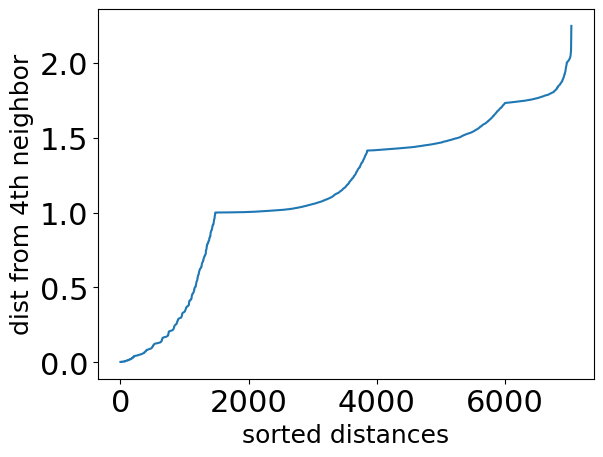

In [ ]:
dist = pdist(X, 'euclidean')
dist = squareform(dist) 
k = 4
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

plt.plot(range(0, len(kth_distances)), sorted(kth_distances))
plt.ylabel('dist from %sth neighbor' % k, fontsize=18)
plt.xlabel('sorted distances', fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Supervised learning

In [ ]:
metrics = ['roc_auc', 'accuracy', 'precision', 'recall', 'f1']

#### Logistic regression

In [ ]:
logistic_regression(telco_df, {'C': np.logspace(-4, 4, 100, base=10)})

{'random_state': 42}
| roc_auc: 0.8485 | accuracy: 0.8059 - cross-validation
| roc_auc: 0.8319 | accuracy: 0.7875 - test set
Best hyperparameters: {'C': np.float64(12.328467394420684)}


#### Support Vector Machine

In [ ]:
grid_rbf =  {'C': np.logspace(-4, 1, 10, base=2), 'gamma': np.logspace(-6, 2, 10, base=2)}
svc_rbf(telco_df, grid_rbf)

{'kernel': 'rbf', 'probability': True, 'random_state': 42}
| roc_auc: 0.8375 | accuracy: 0.7989 - cross-validation
| roc_auc: 0.8189 | accuracy: 0.7939 - test set
Best hyperparameters: {'C': np.float64(0.19842513149602498), 'gamma': np.float64(0.015625)}


#### Random forest

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}
random_forest(telco_df, param_grid)

{'random_state': 42}
| roc_auc: 0.8473 | accuracy: 0.8049 | precision: 0.6694 | recall: 0.5295 | f1: 0.5906 - cross-validation
Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            938             95
Actual Yes           189            185
| roc_auc: 0.8302 | accuracy: 0.7982 | precision: 0.6607 | recall: 0.4947 | f1: 0.5657 - test set
Best hyperparameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200}


#### Decision tree

{'random_state': 42}
| roc_auc: 0.8279 | accuracy: 0.7902 | precision: 0.6175 | recall: 0.5554 | f1: 0.5834 - cross-validation
Confusion Matrix:
             Predicted No  Predicted Yes
Actual No            937             96
Actual Yes           203            171
| roc_auc: 0.8121 | accuracy: 0.7875 | precision: 0.6404 | recall: 0.4572 | f1: 0.5335 - test set


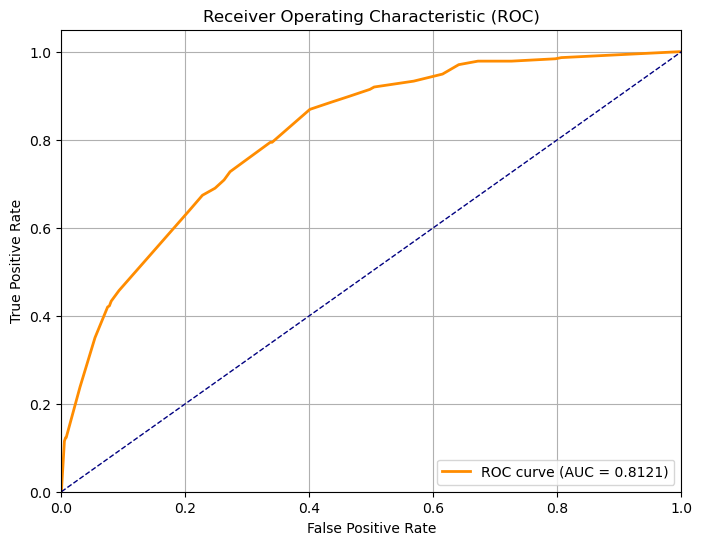

Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


In [ ]:
param_grid = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
}
decision_tree(telco_df, param_grid)

### Association rules

In [51]:
telco_df_ar = telco_df_ar.drop('gender',axis=1)
telco_df_ar = telco_df_ar.drop('TotalCharges',axis=1)

In [52]:
telco_df_ar = map_numerical_to_categorical(telco_df_ar, 'tenure')
telco_df_ar = map_numerical_to_categorical(telco_df_ar, 'MonthlyCharges')

In [53]:
telco_df_ar, _ = map_categorical_to_num(telco_df_ar, one_hot=True)

In [ ]:
telco_df_ar = pd.get_dummies(telco_df_ar, columns=['SeniorCitizen']) # One-hot encoding

In [59]:
telco_df_ar = pd.get_dummies(telco_df_ar, columns=['Churn'])

In [60]:
frequent_itemsets = apriori(telco_df_ar, min_support=0.05, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.6)

/home/iridhexx/miniconda3/envs/ai/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [63]:
churn_rules = rules[rules['consequents'].apply(lambda x: 'Churn_1' in x)]
churn_rules.sort_values(by='lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1214170,"(PaymentMethod_Electronic check, tenurebin_Low...","(Churn_1, PhoneService, OnlineSecurity_No, Con...",0.077666,0.152208,0.051541,0.663620,4.359957,1.0,0.039719,2.520339,0.835532,0.289013,0.603228,0.501120
876287,"(Partner, tenurebin_Low, InternetService_Fiber...","(Churn_1, PhoneService, OnlineSecurity_No, Con...",0.084623,0.152208,0.054806,0.647651,4.255043,1.0,0.041926,2.406115,0.835705,0.301092,0.584392,0.503863
1212543,"(OnlineSecurity_No, TechSupport_No, tenurebin_...","(OnlineBackup_No, Contract_Month-to-month, Chu...",0.095556,0.147380,0.059918,0.627043,4.254590,1.0,0.045835,2.286108,0.845779,0.327386,0.562575,0.516797
1212548,"(tenurebin_Low, InternetService_Fiber optic, O...","(Churn_1, PhoneService, OnlineSecurity_No, Con...",0.092574,0.152208,0.059918,0.647239,4.252338,1.0,0.045827,2.403306,0.842863,0.324117,0.583907,0.520448
1213478,"(DeviceProtection_No, tenurebin_Low, InternetS...","(Churn_1, PhoneService, OnlineSecurity_No, Con...",0.090586,0.152208,0.058214,0.642633,4.222076,1.0,0.044426,2.372331,0.839167,0.315385,0.578474,0.512548
1211634,"(DeviceProtection_No, OnlineSecurity_No, tenur...","(OnlineBackup_No, Contract_Month-to-month, Chu...",0.083203,0.147380,0.051399,0.617747,4.191518,1.0,0.039136,2.230514,0.830525,0.286846,0.551673,0.483248
1213477,"(OnlineSecurity_No, TechSupport_No, tenurebin_...","(DeviceProtection_No, Contract_Month-to-month,...",0.095556,0.145393,0.058214,0.609212,4.190121,1.0,0.044321,2.186885,0.841780,0.318570,0.542729,0.504802
1215004,"(TechSupport_No, tenurebin_Low, InternetServic...","(DeviceProtection_No, Contract_Month-to-month,...",0.086043,0.145393,0.052392,0.608911,4.188046,1.0,0.039882,2.185199,0.832889,0.292625,0.542376,0.484631
1214999,"(DeviceProtection_No, TechSupport_No, tenurebi...","(PhoneService, Contract_Month-to-month, Churn_...",0.084907,0.147380,0.052392,0.617057,4.186832,1.0,0.039879,2.226491,0.831780,0.291239,0.550863,0.486274
1214166,"(Contract_Month-to-month, PaymentMethod_Electr...","(OnlineSecurity_No, TechSupport_No, Churn_1, P...",0.077382,0.160017,0.051541,0.666055,4.162401,1.0,0.039158,2.515334,0.823476,0.277311,0.602438,0.494075


In [65]:
# First, convert frozen sets to readable strings
churn_rules['antecedents_str'] = churn_rules['antecedents'].apply(lambda x: ', '.join(sorted(x)))
churn_rules['consequents_str'] = churn_rules['consequents'].apply(lambda x: ', '.join(sorted(x)))

# Then, create a 'rule' column
churn_rules['rule'] = churn_rules.apply(lambda row: f"{row['antecedents_str']} => {row['consequents_str']}", axis=1)

# Select and format relevant columns
top_rules = churn_rules[['rule', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10)

# Display with better formatting
print(top_rules.to_string(index=False))

                                                                                                                                                           rule  support  confidence     lift
InternetService_Fiber optic, PaymentMethod_Electronic check, tenurebin_Low => Churn_1, Contract_Month-to-month, OnlineSecurity_No, PhoneService, TechSupport_No 0.051541    0.663620 4.359957
                       InternetService_Fiber optic, Partner, tenurebin_Low => Churn_1, Contract_Month-to-month, OnlineSecurity_No, PhoneService, TechSupport_No 0.054806    0.647651 4.255043
               InternetService_Fiber optic, OnlineSecurity_No, TechSupport_No, tenurebin_Low => Churn_1, Contract_Month-to-month, OnlineBackup_No, PhoneService 0.059918    0.627043 4.254590
               InternetService_Fiber optic, OnlineBackup_No, tenurebin_Low => Churn_1, Contract_Month-to-month, OnlineSecurity_No, PhoneService, TechSupport_No 0.059918    0.647239 4.252338
           DeviceProtection_No, InternetService_Fi

/tmp/ipykernel_37954/188360049.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_rules['antecedents_str'] = churn_rules['antecedents'].apply(lambda x: ', '.join(sorted(x)))
/tmp/ipykernel_37954/188360049.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  churn_rules['consequents_str'] = churn_rules['consequents'].apply(lambda x: ', '.join(sorted(x)))
/tmp/ipykernel_37954/188360049.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in